# Imports


In [5]:
import os
import re
from collections import Counter
import pandas as pd
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
data_dir = "/content/drive/MyDrive/DSCI592/csv"
main_dir = "/content/drive/MyDrive/DSCI592"

In [12]:
csv_files = [file for file  in os.listdir(data_dir) if file.endswith(".csv")]
csv_files


['calc_case_description_test_set.csv',
 'dicom_info.csv',
 'calc_case_description_train_set.csv',
 'meta.csv',
 'mass_case_description_train_set.csv',
 'mass_case_description_test_set.csv']

In [13]:
dfs = [pd.read_csv(os.path.join(data_dir, file)) for file in csv_files]

# Print summary comparison of shapes
print("CSV File Shapes:\n")
for file, df in zip(csv_files, dfs):
    print(f"{file}: {df.shape[0]} rows × {df.shape[1]} columns")

CSV File Shapes:

calc_case_description_test_set.csv: 326 rows × 14 columns
dicom_info.csv: 10237 rows × 38 columns
calc_case_description_train_set.csv: 1546 rows × 14 columns
meta.csv: 6775 rows × 9 columns
mass_case_description_train_set.csv: 1318 rows × 14 columns
mass_case_description_test_set.csv: 378 rows × 14 columns


#Calcification and Mass Train and test

In [23]:
import pandas as pd


calc_train = pd.read_csv(os.path.join(data_dir,"calc_case_description_train_set.csv"))
calc_test = pd.read_csv(os.path.join(data_dir,"calc_case_description_test_set.csv"))
mass_train = pd.read_csv(os.path.join(data_dir,"mass_case_description_train_set.csv"))
mass_test = pd.read_csv(os.path.join(data_dir,"mass_case_description_test_set.csv"))

calc_train['lesion_type'] = 'calcification'
calc_test['lesion_type'] = 'calcification'
mass_train['lesion_type'] = 'mass'
mass_test['lesion_type'] = 'mass'

calc_train['split'] = 'train'
calc_test['split'] = 'test'
mass_train['split'] = 'train'
mass_test['split'] = 'test'

all_cases = pd.concat([calc_train, calc_test, mass_train, mass_test], ignore_index=True)

all_cases['participant_id'] = all_cases['patient_id'].str.extract(r'P_(\d{5})') # extract patient id (multiple participant_ids per patient)

print(f"Total cases: {len(all_cases)}")
print(f"Unique participants: {all_cases['participant_id'].nunique()}")
all_cases.columns


Total cases: 3568
Unique participants: 1566


Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path', 'lesion_type', 'split',
       'breast_density', 'mass shape', 'mass margins', 'participant_id'],
      dtype='object')

#Missing data points

In [45]:
all_cases.isna().sum()

,0
patient_id,0
breast density,1696
left or right breast,0
image view,0
abnormality id,0
abnormality type,0
calc type,1720
calc distribution,2135
assessment,0
pathology,0


In [27]:
all_cases.describe(include=[np.number])


,breast density,abnormality id,assessment,subtlety,breast_density
count,1872.000000,3568.000000,3568.000000,3568.000000,1696.000000
mean,2.669338,1.252242,3.396581,3.647422,2.246462
std,0.932322,0.705416,1.314327,1.182583,0.874071
min,0.000000,1.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,3.000000,3.000000,2.000000
50%,3.000000,1.000000,4.000000,4.000000,2.000000
75%,3.000000,1.000000,4.000000,5.000000,3.000000
max,4.000000,7.000000,5.000000,5.000000,4.000000


In [29]:
all_cases.describe(include=['object', 'category', 'bool'])

,patient_id,left or right breast,image view,abnormality type,calc type,calc distribution,pathology,image file path,cropped image file path,ROI mask file path,lesion_type,split,mass shape,mass margins,participant_id,is_abnormal
count,3568,3568,3568,3568,1848,1433,3568,3568,3568,3568,3568,3568,1692,1636,3568,3568
unique,1566,2,2,2,47,9,3,3103,3568,3568,2,2,20,19,1566,2
top,P_01437,LEFT,MLO,calcification,PLEOMORPHIC,CLUSTERED,MALIGNANT,Calc-Training_P_00112_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Test_P_01795_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_01795_LEFT_MLO_1/1.3.6.1.4.1.9590....,calcification,train,IRREGULAR,CIRCUMSCRIBED,01437,True
freq,24,1819,1896,1872,813,935,1457,7,1,1,1872,2864,464,392,24,2886


Case Counts:
 is_abnormal
Abnormal    2886
Normal       682
Name: count, dtype: int64

Case Percentages:
 is_abnormal
Abnormal    80.89
Normal      19.11
Name: proportion, dtype: float64


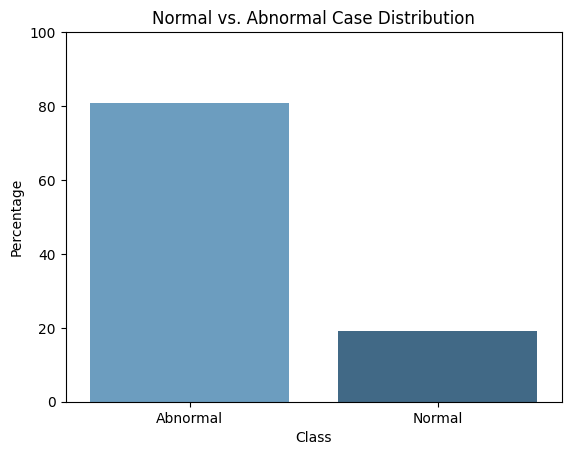

In [28]:
all_cases.describe(include=['object', 'category', 'bool'])


all_cases['is_abnormal'] = all_cases['pathology'] != 'BENIGN_WITHOUT_CALLBACK'

counts = all_cases['is_abnormal'].value_counts().rename(index={True: 'Abnormal', False: 'Normal'})
print("Case Counts:\n", counts)

percentages = all_cases['is_abnormal'].value_counts(normalize=True).rename(index={True: 'Abnormal', False: 'Normal'}) * 100
print("\nCase Percentages:\n", percentages.round(2))

plot_df = percentages.reset_index()
plot_df.columns = ['Class', 'Percentage']

sns.barplot(data=plot_df, x='Class', y='Percentage', hue='Class', palette='Blues_d', legend=False)
plt.ylabel('Percentage')
plt.title('Normal vs. Abnormal Case Distribution')
plt.ylim(0, 100)
plt.show()


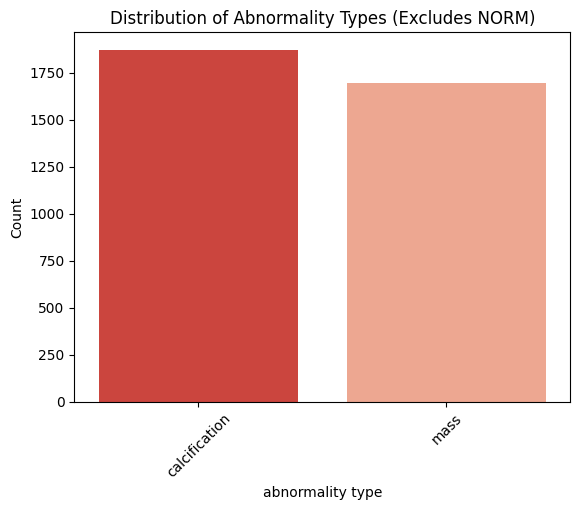

In [38]:
abnormal_df = all_cases[all_cases['abnormality type'] != 'NORM']

abn_counts = abnormal_df['abnormality type'].value_counts()
abn_plot_df = abn_counts.reset_index()
abn_plot_df.columns = ['abnormality type', 'Count']

sns.barplot(data=abn_plot_df,x='abnormality type', y='Count', hue='abnormality type' ,palette='Reds_r')
plt.ylabel('Count')
plt.title('Distribution of Abnormality Types (Excludes NORM)')
plt.xticks(rotation=45)
plt.show()


#Mass shapes - maybe simplify the mass shape categories, particularly the rare and combined labels, either by grouping them into broader categories?

In [39]:
shape_counts = all_cases['mass shape'].value_counts()
print(shape_counts)


mass shape
IRREGULAR                                   464
OVAL                                        412
LOBULATED                                   384
ROUND                                       164
ARCHITECTURAL_DISTORTION                    103
IRREGULAR-ARCHITECTURAL_DISTORTION           52
LYMPH_NODE                                   35
FOCAL_ASYMMETRIC_DENSITY                     25
ASYMMETRIC_BREAST_TISSUE                     25
LOBULATED-IRREGULAR                           6
OVAL-LYMPH_NODE                               6
LOBULATED-LYMPH_NODE                          4
ROUND-OVAL                                    3
LOBULATED-ARCHITECTURAL_DISTORTION            2
IRREGULAR-FOCAL_ASYMMETRIC_DENSITY            2
LOBULATED-OVAL                                1
ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION      1
ROUND-LOBULATED                               1
OVAL-LOBULATED                                1
IRREGULAR-ASYMMETRIC_BREAST_TISSUE            1
Name: count, dtype: int64


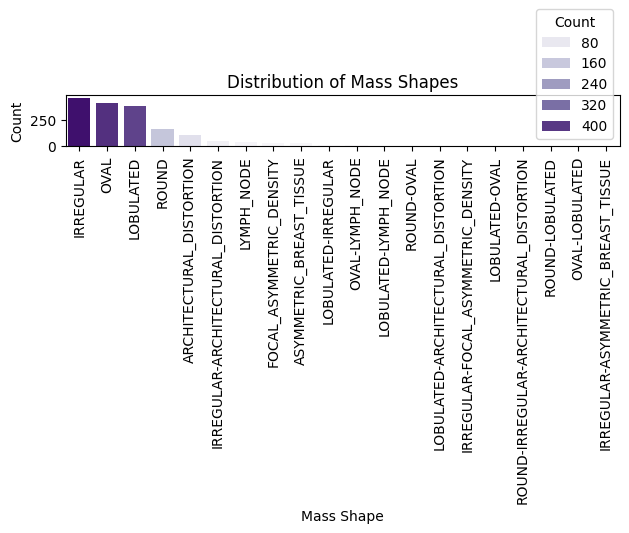

In [43]:
shape_df = shape_counts.reset_index()
shape_df.columns = ['Mass Shape', 'Count']

sns.barplot(data=shape_df, x='Mass Shape', y='Count', hue = 'Count',palette='Purples')
plt.xticks(rotation=90)
plt.title('Distribution of Mass Shapes')
plt.tight_layout()
plt.show()


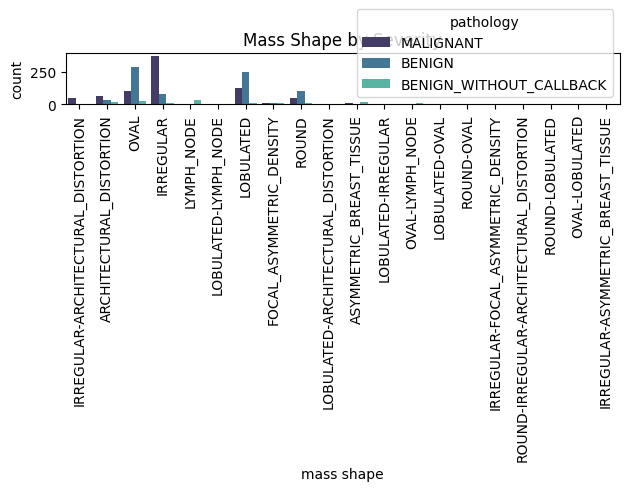

In [50]:
sns.countplot(data=all_cases, x='mass shape', hue='pathology', palette='mako')
plt.xticks(rotation=90)
plt.title('Mass Shape by Severity')
plt.tight_layout()
plt.show()


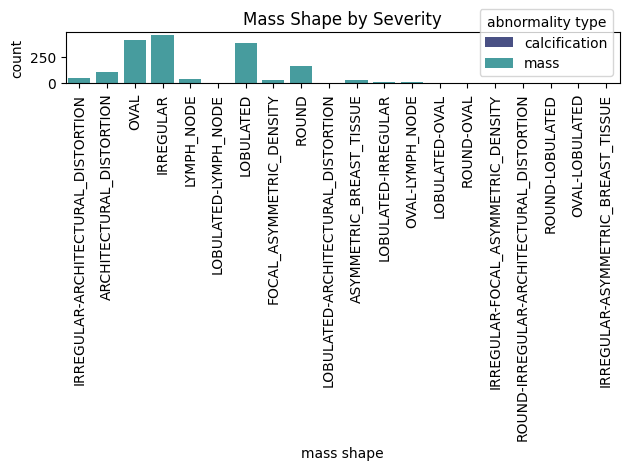

In [64]:
sns.countplot(data=all_cases, x='mass shape', hue='abnormality type', palette='mako')
plt.xticks(rotation=90)
plt.title('Mass Shape by Severity')
plt.tight_layout()
plt.show()
## Caes with calcification abnormality have no mass shape